<a href="https://colab.research.google.com/github/lollipop6370/ML2021/blob/main/hw12_ppo_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package And Building Environment

In [1]:
!apt update
!apt install python3-opengl xvfb -y
!pip uninstall box2d box2d-py -y
!pip install swig
!pip install box2d-py==2.3.8
!pip install gymnasium[box2d] --no-deps
!pip install pyvirtualdisplay tqdm numpy torch

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,802 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,753 kB]
Get:13 http://security.ubuntu.com/ubun

In [53]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import itertools

In [54]:
seed = 543 # Do not change this (543)
def fix(env, seed):
  obs, info = env.reset(seed=seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [55]:
%%capture
import gymnasium as gym
import random
import numpy as np

env = gym.make('LunarLander-v3', render_mode="rgb_array")

fix(env, seed)

import time
start = time.time()

In [56]:
!pip freeze

absl-py==1.4.0
accelerate==1.8.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.23.0.39.50
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
Bottleneck==1.4.2
box2d-py==2.3.8
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.6.15
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake=

# 1. Building Actor And Critic Network

# Actor

In [57]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4),
            nn.Softmax(dim=-1)
        )

    def forward(self, observation):
        action = self.net(observation)
        return action

# Critic

In [58]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, observation):
        return self.net(observation)

# 2. Building AI Agent

In [63]:
class Agent():
    def __init__(self):
        # hyperparameter
        self.gamma = 0.99
        self.epsilon = 0.2
        self.kepochs = 10

        self.memory = []

        self.lr = 8e-4

        # 1. create actor and critic
        self.actor = Actor()
        self.actor_old = Actor()
        self.actor_old.load_state_dict(self.actor.state_dict())
        self.critic = Critic()

        # 2. determined optimizer
        self.all_parameters = itertools.chain(self.actor.parameters(), self.critic.parameters())
        self.optimizer = optim.Adam(self.all_parameters, lr=self.lr)

    # 3. sampling a action
    def sample(self, observation):
        # sample a action from old actor.
        observation_tensor = torch.tensor(observation, dtype=torch.float32)
        action_prob = self.actor_old(observation_tensor)
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)

        return action.item(), log_prob

    # 4. learning
    def learn(self):

        # take data from memory
        observations, actions, old_log_probs, rewards, dones = zip(*self.memory)
        # change data type to tensor
        observations_tensor = torch.tensor(np.array(observations), dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        old_log_probs = torch.stack(old_log_probs).detach()

        # calculat discount rewards
        discount_rewards = 0
        rewards_to_go = []
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                discount_rewards = 0
            discount_rewards = r + discount_rewards * self.gamma
            rewards_to_go.insert(0, discount_rewards)
        # change data type
        rewards_to_go_tensor = torch.tensor(rewards_to_go, dtype=torch.float32)

        #with torch.no_grad():
        #    values_for_gae = self.critic(observations_tensor).squeeze()

        # calculate GAE advantage
        #advantage = self.compute_gae(rewards, values_for_gae, dones)
        # normalization advantage
        #advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # training module for kepochs
        for epoch in range(self.kepochs):

            # get critic value
            value = self.critic(observations_tensor).squeeze()

            # take new actor's distribution
            action_prob = self.actor(observations_tensor)
            action_dist = Categorical(action_prob)
            new_log_prob = action_dist.log_prob(actions_tensor)

            # take entropy
            entropys_tensor = action_dist.entropy()

            # calculate ratio
            # we need new_prob / old_prob
            # exp(log(a)-log(b)) = exp(log(a/b)) = a/b
            ratio = torch.exp(new_log_prob - old_log_probs)

            # calculate advantage
            advantage = (rewards_to_go_tensor - value).detach()
            # normalization
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            # actor loss
            loss_actor = - torch.min(ratio * advantage, torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage).mean()

            # critic loss
            loss_critic = F.mse_loss(value, rewards_to_go_tensor)

            # entropy loss
            loss_entropy = - entropys_tensor.mean()

            # loss function
            loss = loss_actor + 1.0 * loss_critic + 0.01 * loss_entropy

            # update actor
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.actor_old.load_state_dict(self.actor.state_dict())

        # clean memory
        self.memory = []

    def compute_gae(self, rewards, values, dones, lam=0.95):
        """
        rewards: List of float
        values: torch.Tensor, shape [T], detached
        dones: List of bool
        """
        advantages = []
        gae = 0
        values = values.tolist() + [0.0]  # append V(s_{T+1}) = 0 for terminal
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * lam * (1 - dones[t]) * gae
            advantages.insert(0, gae)

        return torch.tensor(advantages, dtype=torch.float32)

    def store_transition(self, observation, action, log_prob, reward, done):
        self.memory.append((observation, action, log_prob, reward, done))

    # 5. save module
    def save(self, PATH):
        dictionary = {
            "network": {
                "actor": self.actor.state_dict(),
                "critic": self.critic.state_dict()
            },
            "optimizer": self.optimizer.state_dict()
        }
        torch.save(dictionary, PATH)

    # 6. load module
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.actor.load_state_dict(checkpoint["network"]["actor"])
        self.critic.load_state_dict(checkpoint["network"]["critic"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.actor_old.load_state_dict(self.actor.state_dict())

# 3. Training

In [64]:
agent = Agent()

In [65]:
# initial some setting
agent.actor.train()
agent.critic.train()
MAX_STEP = 2500000 # total training step
UPDATE_STEP = 2048 # unmber of update step
time_step = 0

observation, _ = env.reset(seed=seed) #
avg_rewards_per_batch = []
episode_reward = []
reward_sum = 0

# training start
prg_bar = tqdm(range(MAX_STEP))
for step in prg_bar:

    # Learning Rate Annealing
    frac = 1.0 - (step - 1.0) / MAX_STEP
    new_lr = agent.lr * frac
    for param_group in agent.optimizer.param_groups:
        param_group["lr"] = new_lr

    # 1. sample action from old actor.
    action, log_prob = agent.sample(observation)

    # 2. interact with the environment.
    next_observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    reward_sum += reward

    # 3. save data
    agent.store_transition(observation, action, log_prob, reward, done)

    observation = next_observation
    time_step += 1

    # 4. if collect enough data, update module.
    if time_step % UPDATE_STEP == 0:
        if len(episode_reward) != 0:
            avg_rewards_per_batch.append(sum(episode_reward) / len(episode_reward))
            print(f"every episode average reward = ", sum(episode_reward) / len(episode_reward))
            episode_reward = []
        agent.learn()
        time_step = 0

    if done:
        episode_reward.append(reward_sum)
        reward_sum = 0
        observation, _ = env.reset(seed=seed) #

  0%|          | 0/2500000 [00:00<?, ?it/s]

every episode average reward =  -96.70951833496312
every episode average reward =  -75.33576888851147
every episode average reward =  -49.525324467368094
every episode average reward =  -70.87242033629826
every episode average reward =  -40.932837549298206
every episode average reward =  -49.308044013429544
every episode average reward =  -51.821798411882675
every episode average reward =  -68.75531065828076
every episode average reward =  -50.70902705254594
every episode average reward =  -41.53861223115227
every episode average reward =  -49.525238322298335
every episode average reward =  -20.905287465628966
every episode average reward =  -26.799849294981815
every episode average reward =  -109.79366513403816
every episode average reward =  -78.99765095921724
every episode average reward =  -18.826587290422786
every episode average reward =  -18.464735223045157
every episode average reward =  -17.298326797043693
every episode average reward =  -56.3365393670947
every episode average

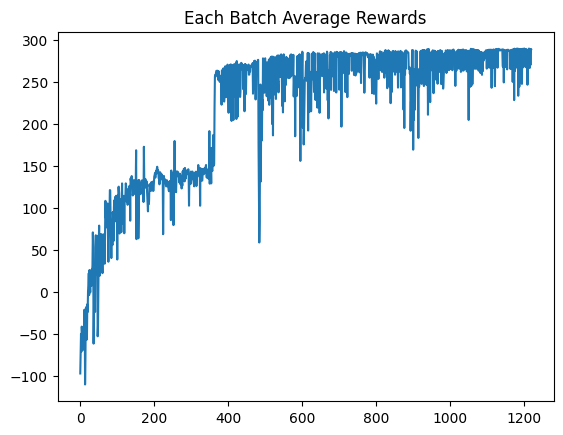

In [66]:
end = time.time()
plt.plot(avg_rewards_per_batch)
plt.title("Each Batch Average Rewards")
plt.show()

# Test

episode finished ! reward =  -135.2605904735837
lenght of actions =  464
episode finished ! reward =  23.78689461555618
lenght of actions =  128
episode finished ! reward =  -10.658722098322627
lenght of actions =  188
episode finished ! reward =  275.1842095083914
lenght of actions =  155
episode finished ! reward =  247.5591986230031
lenght of actions =  214


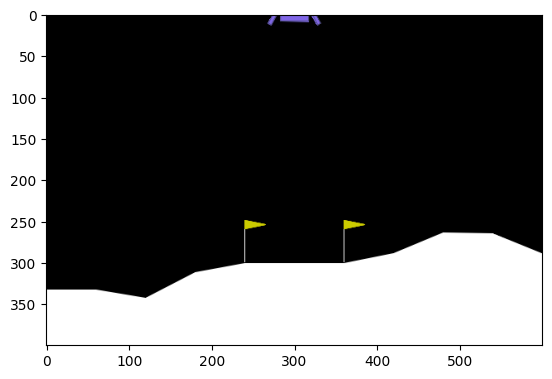

In [74]:
fix(env, seed)
agent.actor.eval()
agent.critic.eval()
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_lists = []
for i in range(NUM_OF_TEST):
    observation, _ = env.reset() # random seed

    img = plt.imshow(env.render())

    rewards = 0
    action_list = []
    while True:
        action, log_prob = agent.sample(observation)
        observation, reward, termination, truncated, _ = env.step(action)
        rewards += reward
        action_list.append(action)

        #img.set_data(env.render())
        #display.display(plt.gcf())
        #display.clear_output(wait=True)

        done = termination or truncated
        if done:
            test_total_reward.append(rewards)
            action_lists.append(action_list)
            print(f"episode finished ! reward = ", rewards)
            print(f"lenght of actions = ", len(action_list))
            break

In [75]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 80.12


In [69]:
print("Action list looks like ", action_lists)
print("Action list's shape looks like ", len(action_lists))

Action list looks like  [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 1, 3, 2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 1, 3, 2, 2, 3, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 3, 3, 2, 2, 2, 1, 2, 2, 3, 2, 3, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2, 2, 3, 1, 2, 3, 2, 2, 3, 1, 2, 2, 3, 2, 1, 3, 2, 3, 0, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 3, 0, 0, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 0, 3, 0, 0, 0, 1, 1,

In [70]:
distribution = {}
for action_list in action_lists:
    for action in action_list:
        if action not in distribution.keys():
            distribution[action] = 1
        else:
            distribution[action] += 1
print(distribution)

{0: 260, 1: 307, 3: 135, 2: 447}
